# Load stuff

In [128]:
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
import scipy.sparse as sps
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import leidenalg
import igraph as ig
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.cm
import umap
import seaborn as sns
from itertools import combinations
from collections import Counter
import networkx as nx
from collections import defaultdict

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Load and clean data

In [129]:
class TextNetworkExtractor:
    """Extracts nodes and edges from a list of text documents for building a weighted network."""

    def __init__(self, texts, n_min, n_max):
        """
        Initialize the text network extractor.

        Args:
            texts: List of strings (documents).
            n_min: Minimum word frequency to keep (default: 2).
            n_max: Maximum word frequency to keep (default: 1e10).
        """
        self.texts = texts
        self.n_min = n_min
        self.n_max = n_max
        self.words = None
        self.word_to_idx = None
        self.co_occurrence_matrix = None
        self.filtered_words = None
        self.filtered_co_occurrence_matrix = None

    def preprocess_text(self):
        """
        Preprocess the text to extract words and build a word-document occurrence matrix.
        """
        # Use CountVectorizer to tokenize and count word occurrences
        vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
        word_doc_matrix = vectorizer.fit_transform(self.texts)

        # Get vocabulary and word-to-index mapping
        self.words = np.array(vectorizer.get_feature_names_out())
        self.word_to_idx = {word: idx for idx, word in enumerate(self.words)}

        # Convert to dense array for filtering
        self.word_doc_matrix = word_doc_matrix.toarray()

    def filter_words_by_frequency(self):
        """
        Filter words based on their frequency in the corpus.
        """
        # Calculate word frequencies
        word_frequencies = self.word_doc_matrix.sum(axis=0)

        # Filter words based on frequency thresholds
        valid_words_mask = (word_frequencies >= self.n_min) & (word_frequencies <= self.n_max)
        self.filtered_words = self.words[valid_words_mask]
        self.filtered_word_doc_matrix = self.word_doc_matrix[:, valid_words_mask]

    def build_co_occurrence_matrix(self, window_size=5):
        """
        Build a co-occurrence matrix for words within a specified window size.

        Args:
            window_size: Size of the sliding window for co-occurrence (default: 5).
        """
        n_words = len(self.filtered_words)
        self.co_occurrence_matrix = np.zeros((n_words, n_words), dtype=int)

        # Build co-occurrence matrix
        for doc in self.filtered_word_doc_matrix:
            for i in range(len(doc)):
                if doc[i] > 0:  # Word i is present in the document
                    for j in range(max(0, i - window_size), min(len(doc), i + window_size + 1)):
                        if j != i and doc[j] > 0:  # Word j is present in the window
                            self.co_occurrence_matrix[i, j] += 1

    def get_nodes_and_edges(self):
        """
        Extract nodes and edges from the co-occurrence matrix.

        Returns:
            nodes: List of words (nodes in the network).
            edges: List of tuples (word1, word2, weight) representing edges.
        """
        nodes = self.filtered_words.tolist()
        edges = []

        # Iterate through the co-occurrence matrix to extract edges
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                weight = self.co_occurrence_matrix[i, j]
                if weight > 0:
                    edges.append((nodes[i], nodes[j], weight))

        return nodes, edges

In [130]:
class CleanText:
    def __init__(self, text, POS_KEEP=["ADJ", "ADV", "NOUN", "PROPN", "VERB"]):
        # Capture execution time
        tic = time.time()
        # Store original text
        self.text = list(text)
        # Superficially clean the text
        sup_clean = [self._superficial_cleaning(i) for i in self.text]
        # Store deep cleaning of text
        self.text_clean = [self._deep_cleaning(i, POS_KEEP) for i in sup_clean]
        # Store deep cleaning of POS
        self.pos_clean = [self._deep_cleaning_pos(i, POS_KEEP) for i in sup_clean]
        # Create a DataFrame
        self.df = self._create_dataframe()
        # Capture execution time
        print(f'Cleaning text: execution time {time.time() - tic} [s]')

    def _superficial_cleaning(self, selftext):
        # Remove any HTML tag
        soup = BeautifulSoup(selftext, "html.parser")
        outtext = soup.get_text(separator=" ")
        # Remove any text inside square brackets
        outtext = re.sub(r'\[.*?\]', '', outtext)
        # Remove any website links
        outtext = re.sub(r'http\S+', '', outtext)
        outtext = re.sub(r'www.\S+', '', outtext)
        outtext = outtext.replace('. com', '.com')
        # Remove '&amp;#x200B;\n\'
        outtext = re.sub(r'&amp;#x200B;\n\\', ' ', outtext)
        outtext = re.sub(r'‚Äú', ' ', outtext)
        outtext = re.sub(r'‚Äô', "’", outtext)
        # Remove double spaces, newlines, tabs, and combinations
        outtext = re.sub(r' +', ' ', outtext)
        outtext = re.sub(r'\s{2,}', ' ', outtext)
        outtext = re.sub(r'&gt;', ' ', outtext)
        outtext = outtext.replace('-', ' ')
        outtext = outtext.replace('\\n', ' ').replace('\n', ' ').replace('\t', ' ').replace('\\', ' ')
        # Reduce repetition to two characters for alphabets and to one character for punctuations
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
        outtext = Pattern_alpha.sub(r"\1\1", outtext)
        outtext = Pattern_Punct.sub(r'\1', outtext)
        outtext = re.sub(' {2,}', ' ', outtext)
        # Remove extra whitespaces from the text
        pattern = re.compile(r'\s+')
        Without_whitespace = re.sub(pattern, ' ', outtext)
        outtext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return outtext

    def _deep_cleaning(self, selftext, POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = ' '.join([token.lemma_ for token in nlp(selftext) if token.pos_ in POS_KEEP])
        return outtext

    def _deep_cleaning_pos(self, selftext, POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = [' '.join([token.lemma_, token.pos_]) for token in nlp(selftext) if token.pos_ in POS_KEEP]
        return outtext

    def _create_dataframe(self):
        # Create a DataFrame with the original text, cleaned text, and POS-cleaned tokens
        df = pd.DataFrame({
            "cleaned_text": self.text_clean})
        return df

    def get_dataframe(self):
        # Return the DataFrame
        return self.df

In [131]:
df = pd.read_csv("cc_TOT.csv")
df = df['cleaned_text'].dropna().tolist()

In [132]:
extractor = TextNetworkExtractor(df, n_min=35, n_max=90)

# Preprocess text
extractor.preprocess_text()

# Filter words by frequency
extractor.filter_words_by_frequency()

# Build co-occurrence matrix
extractor.build_co_occurrence_matrix(window_size=3)

# Extract nodes and edges
nodes, edges = extractor.get_nodes_and_edges()

# Print results
print("Nodes:", nodes)
print("Edges:", edges)

Nodes: ['actually', 'age', 'also', 'always', 'bad', 'base', 'bc', 'be', 'big', 'bro', 'car', 'come', 'country', 'day', 'earth', 'end', 'even', 'ever', 'feel', 'first', 'flower', 'give', 'good', 'grow', 'happen', 'heat', 'here', 'hot', 'house', 'ice', 'last', 'let', 'literally', 'live', 'look', 'man', 'many', 'money', 'most', 'much', 'never', 'now', 'only', 'other', 'planet', 'plant', 'put', 'real', 'really', 'right', 'save', 'show', 'snow', 'start', 'still', 'take', 'talk', 'tell', 'then', 'there', 'thing', 'too', 'tree', 'true', 'try', 'use', 'wait', 'want', 'water', 'way', 'weather', 'well', 'winter', 'world']
Edges: [('actually', 'also', 2), ('age', 'also', 8), ('also', 'bad', 3), ('also', 'base', 5), ('always', 'bc', 2), ('bad', 'bc', 2), ('bad', 'be', 2), ('bc', 'be', 2), ('bc', 'big', 1), ('bc', 'bro', 2), ('be', 'big', 6), ('be', 'bro', 3), ('big', 'come', 2), ('bro', 'car', 2), ('bro', 'come', 1), ('car', 'day', 2), ('come', 'country', 1), ('come', 'day', 3), ('day', 'end', 4),

In [133]:
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)


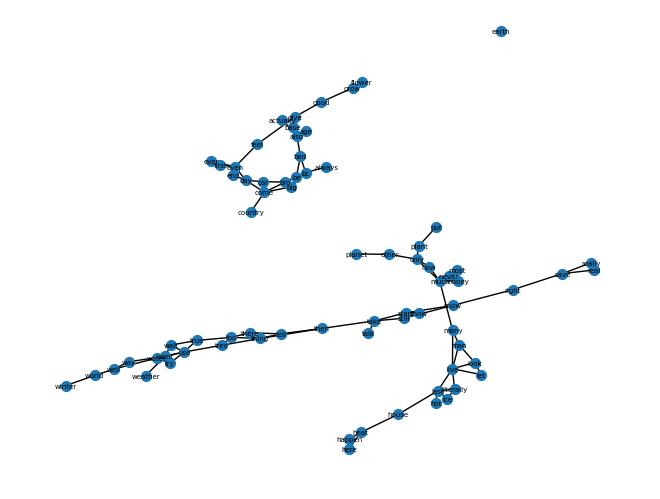

In [134]:
nx.draw(G, with_labels=True, node_size=50, font_size=5)

In [135]:
# convert to ig graph
G = ig.Graph.from_networkx(G)


G.vs["degree"] = G.degree()
G.vs["pagerank"] = G.pagerank()
G.vs["modularity_class"] = G.community_multilevel(weights="weight").membership

In [136]:
for vertex in G.vs:
    print(f"Node: {vertex['_nx_name']}")
    print(f"Degree: {vertex['degree']}")
    print(f"PageRank: {vertex['pagerank']}")
    print(f"Modularity Class: {vertex['modularity_class']}")
    print("-" * 50)

for edge in G.es:
    source = edge.source  # Source node of the edge
    target = edge.target  # Target node of the edge
    weight = edge['weight']  # Weight attribute of the edge
    print(f"Edge: {G.vs[source]['_nx_name']} -> {G.vs[target]['_nx_name']}")
    print(f"Weight: {weight}")
    print("-" * 50)

Node: actually
Degree: 1
PageRank: 0.0074166524747592555
Modularity Class: 0
--------------------------------------------------
Node: age
Degree: 1
PageRank: 0.0074166524747592555
Modularity Class: 0
--------------------------------------------------
Node: also
Degree: 4
PageRank: 0.025252101067340407
Modularity Class: 0
--------------------------------------------------
Node: always
Degree: 1
PageRank: 0.005952293002082747
Modularity Class: 1
--------------------------------------------------
Node: bad
Degree: 3
PageRank: 0.015137845619134888
Modularity Class: 1
--------------------------------------------------
Node: base
Degree: 1
PageRank: 0.0074166524747592555
Modularity Class: 0
--------------------------------------------------
Node: bc
Degree: 5
PageRank: 0.02295124708313722
Modularity Class: 1
--------------------------------------------------
Node: be
Degree: 4
PageRank: 0.017974028895257906
Modularity Class: 1
--------------------------------------------------
Node: big
Degr

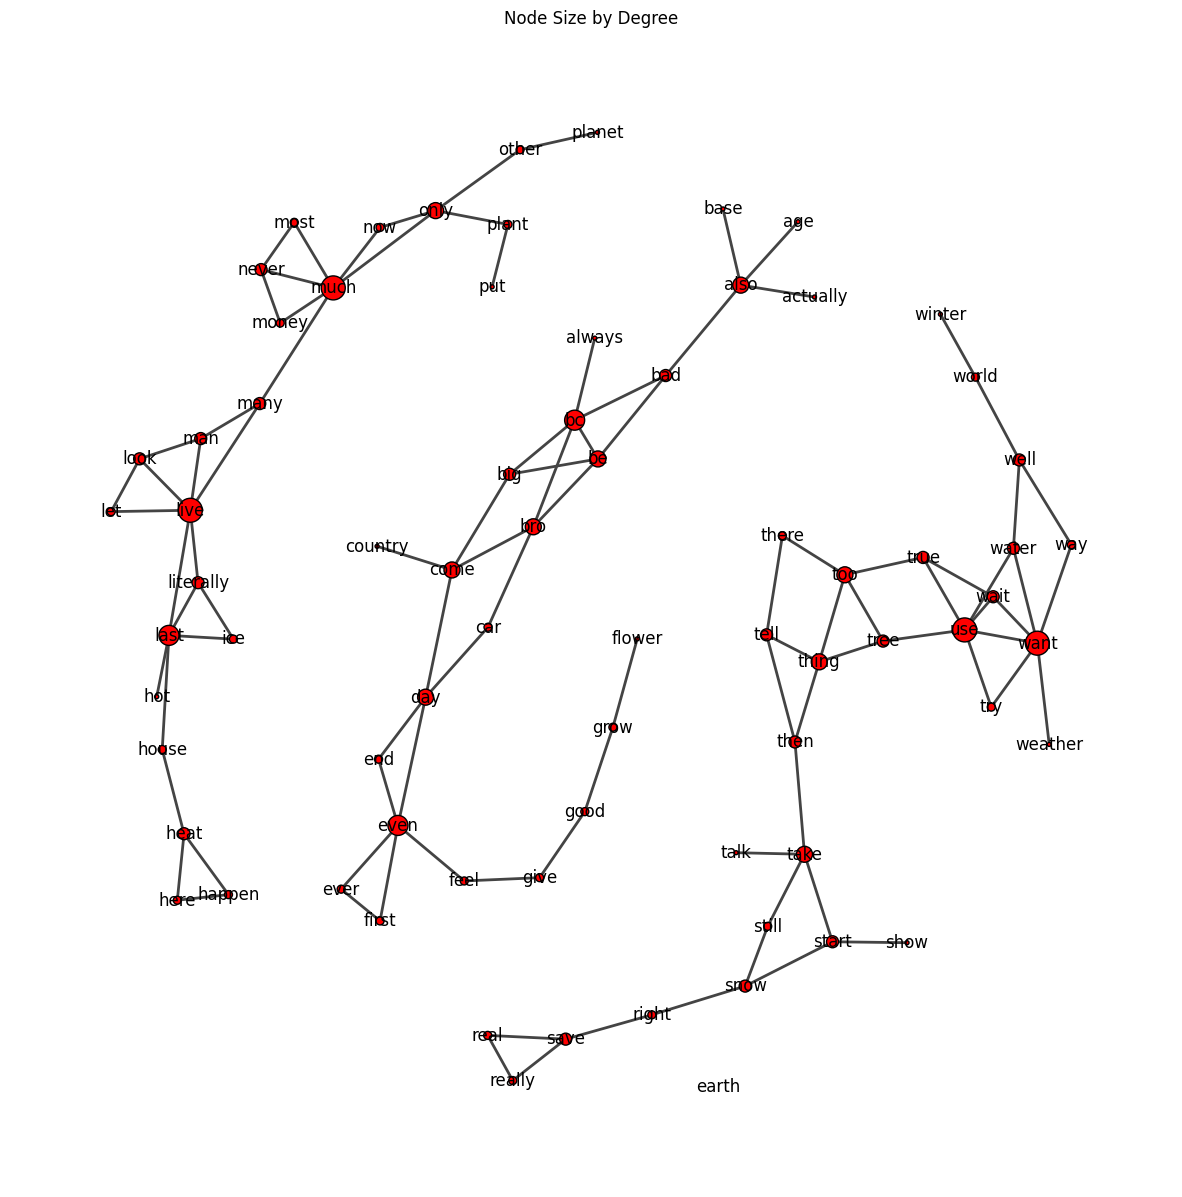

In [137]:
node_sizes = [4 * deg for deg in G.vs["degree"]]  # Scale node size by degree

fig, ax = plt.subplots(figsize=(15, 15))  # Ensure the figure is set

ig.plot(
    G,
    vertex_size=node_sizes,
    vertex_label = G.vs["_nx_name"],
    target=ax,  # Plot directly into the axes
    margin=50
)

plt.title("Node Size by Degree")
plt.show()

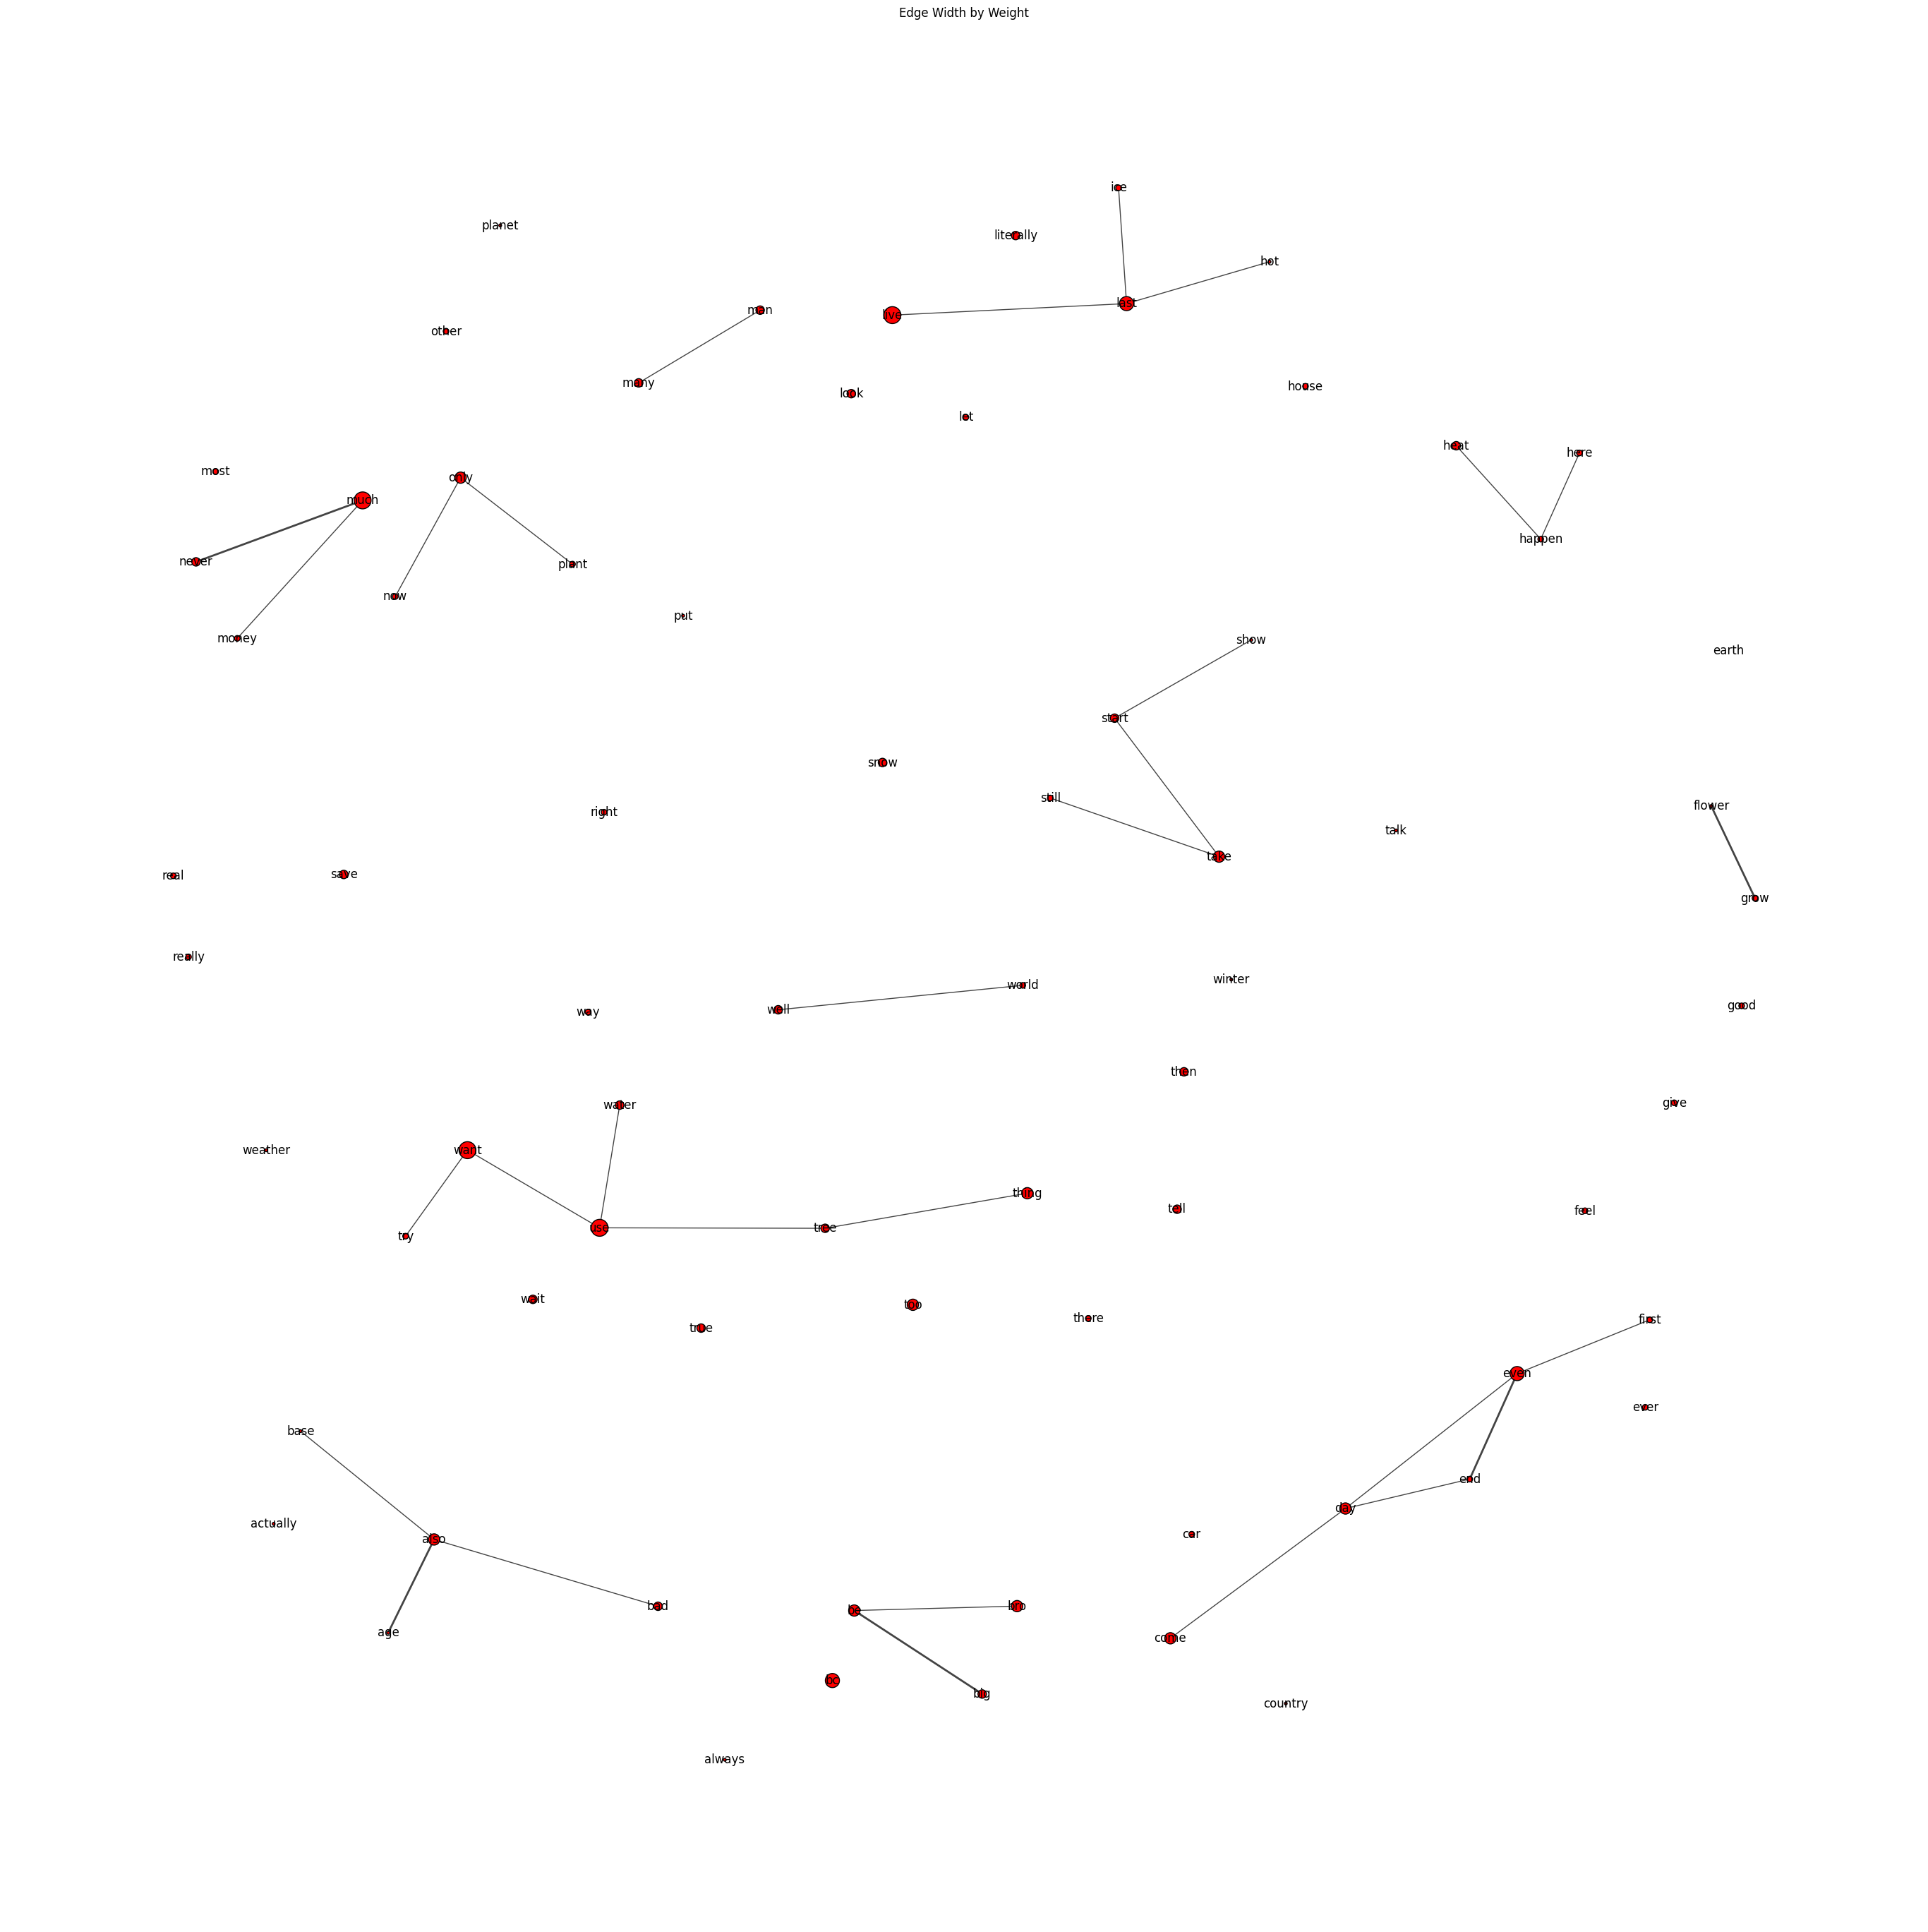

In [138]:
edge_weights = [int(weight/3) for weight in G.es["weight"]]

fig, ax = plt.subplots(figsize=(35, 35))

# Plot the graph
ig.plot(
    G,
    vertex_size=node_sizes,
    vertex_label=G.vs["_nx_name"],
    edge_width=edge_weights,
    target=ax,
    margin=50
)

plt.title("Edge Width by Weight")
plt.show()

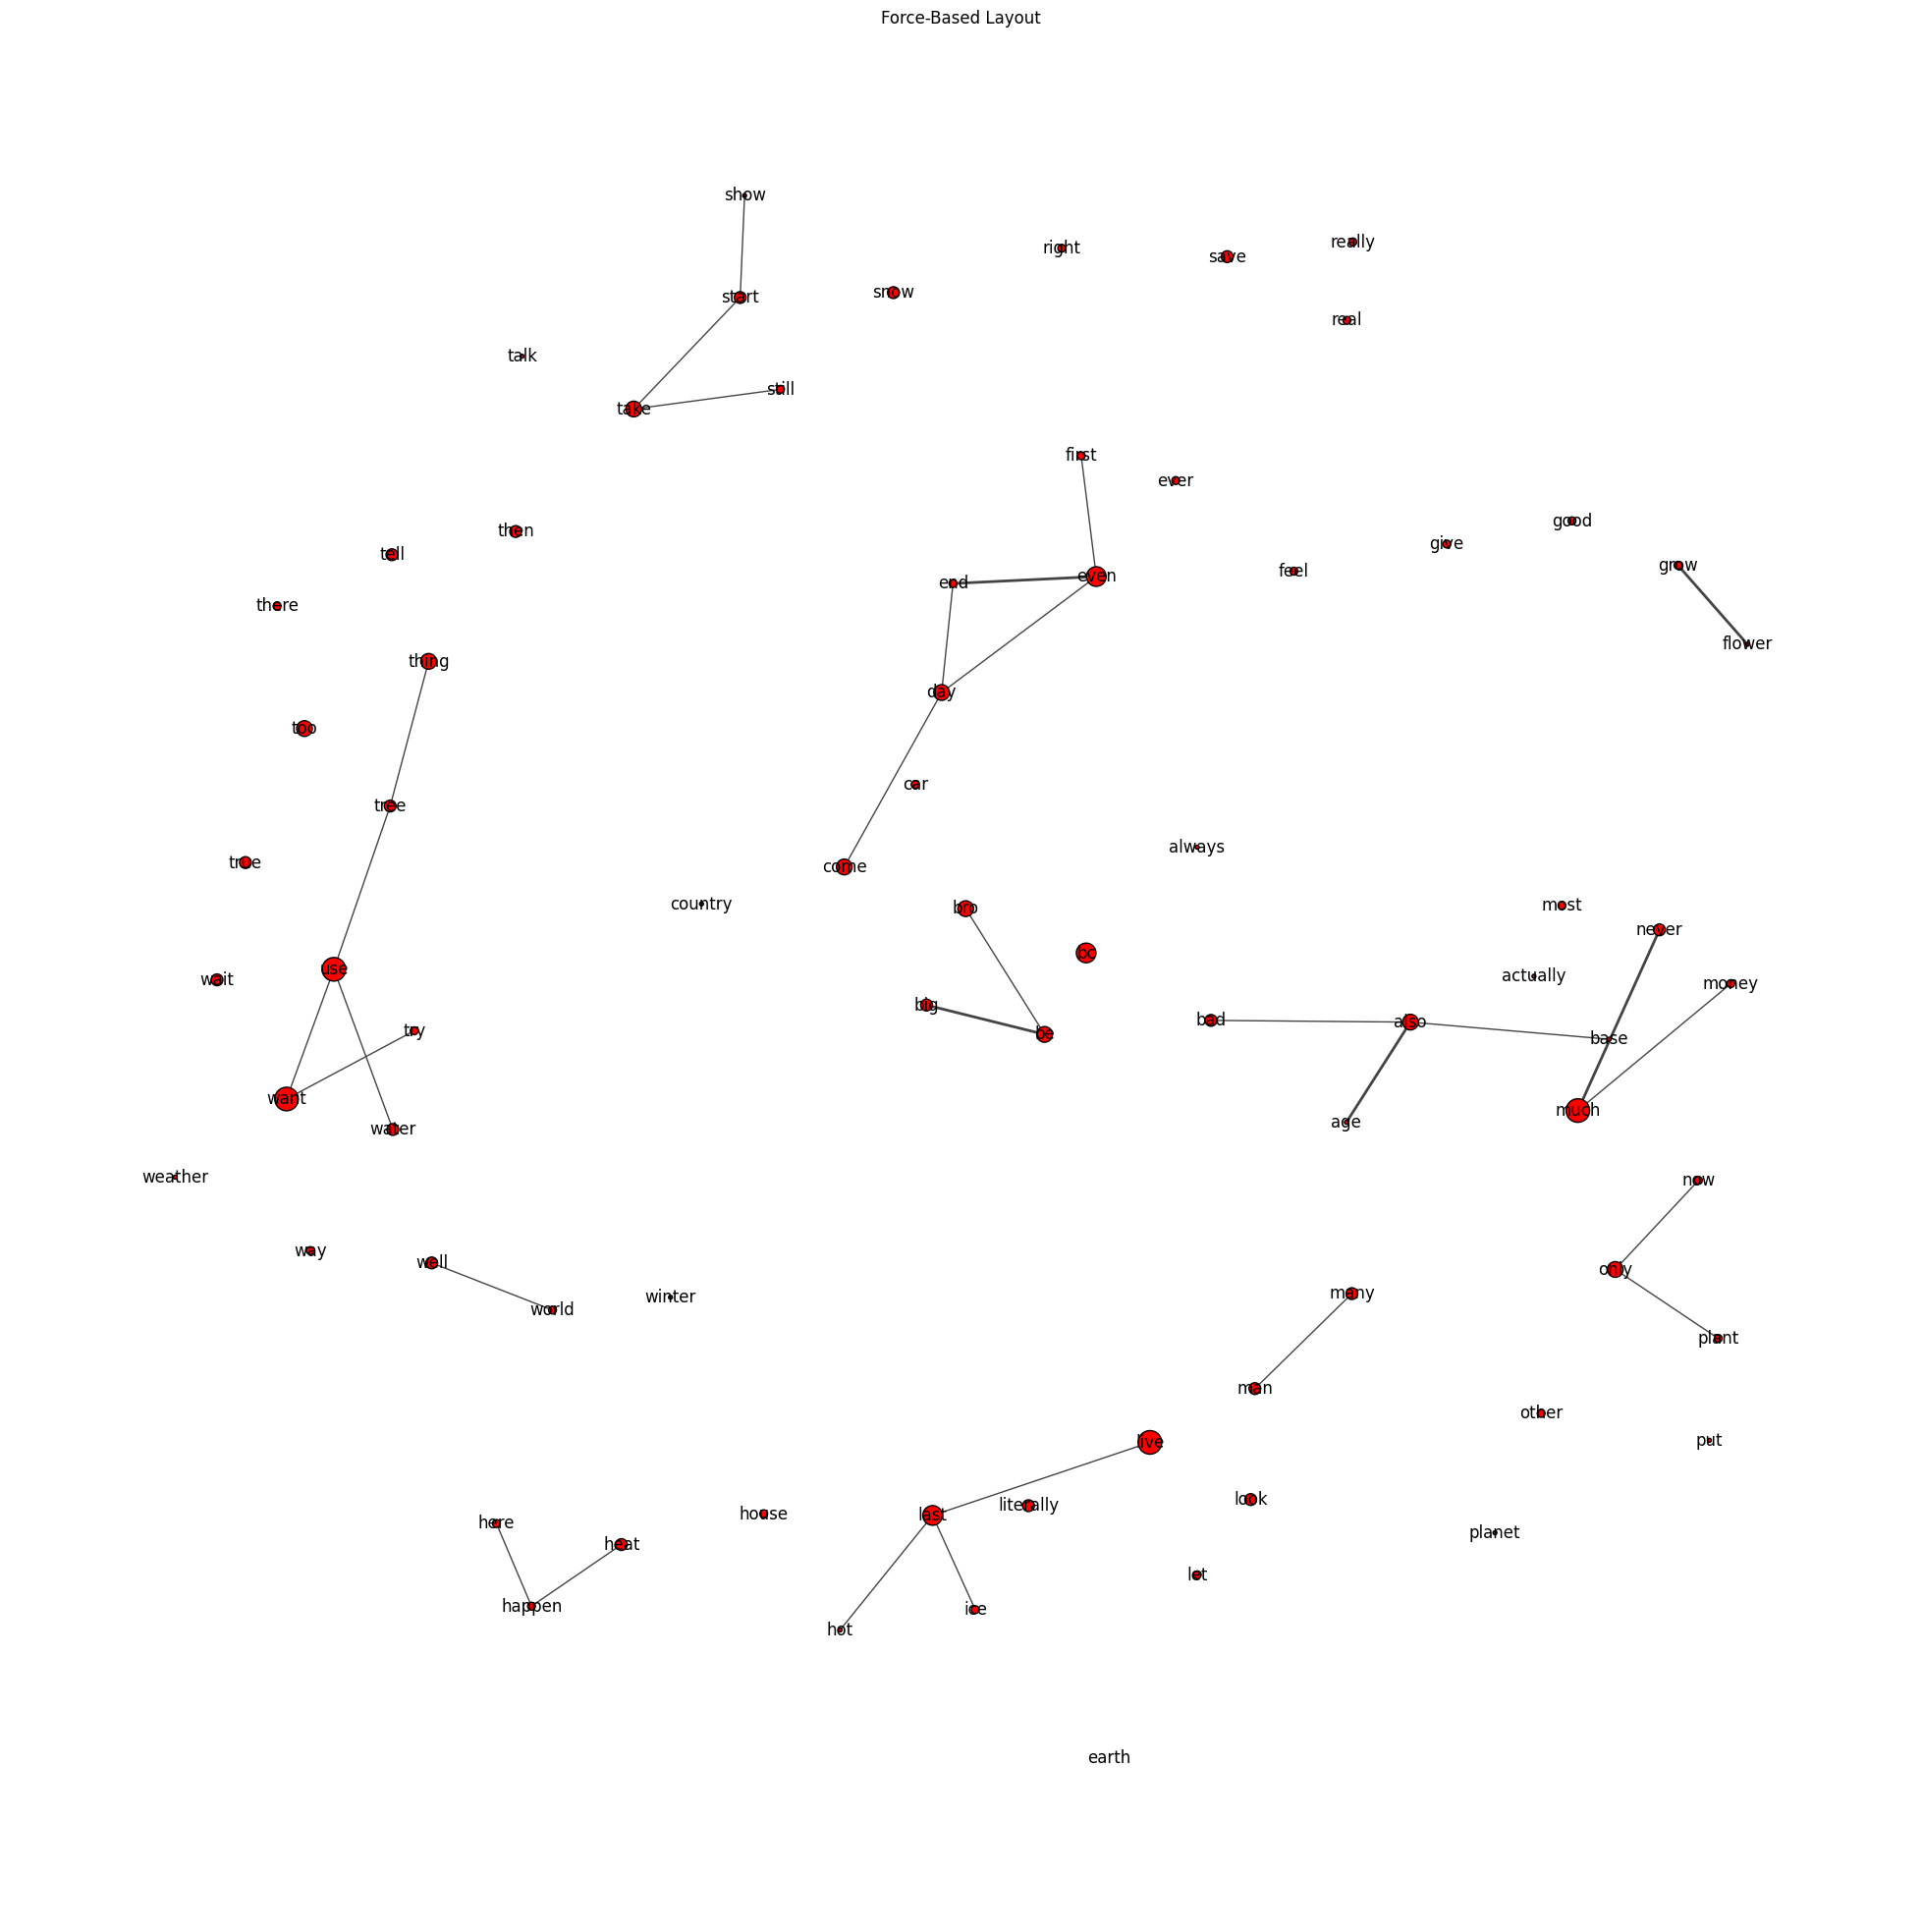

In [139]:
layout_fr = G.layout_fruchterman_reingold()

# Step 4: Force-Based Layout
fig, ax = plt.subplots(figsize=(25, 25))

ig.plot(
    G,
    vertex_size=node_sizes,
    vertex_label=G.vs["_nx_name"],
    edge_width=edge_weights,
    layout=layout_fr,
    target=ax,
    margin=50
)

plt.title("Force-Based Layout")
plt.show()

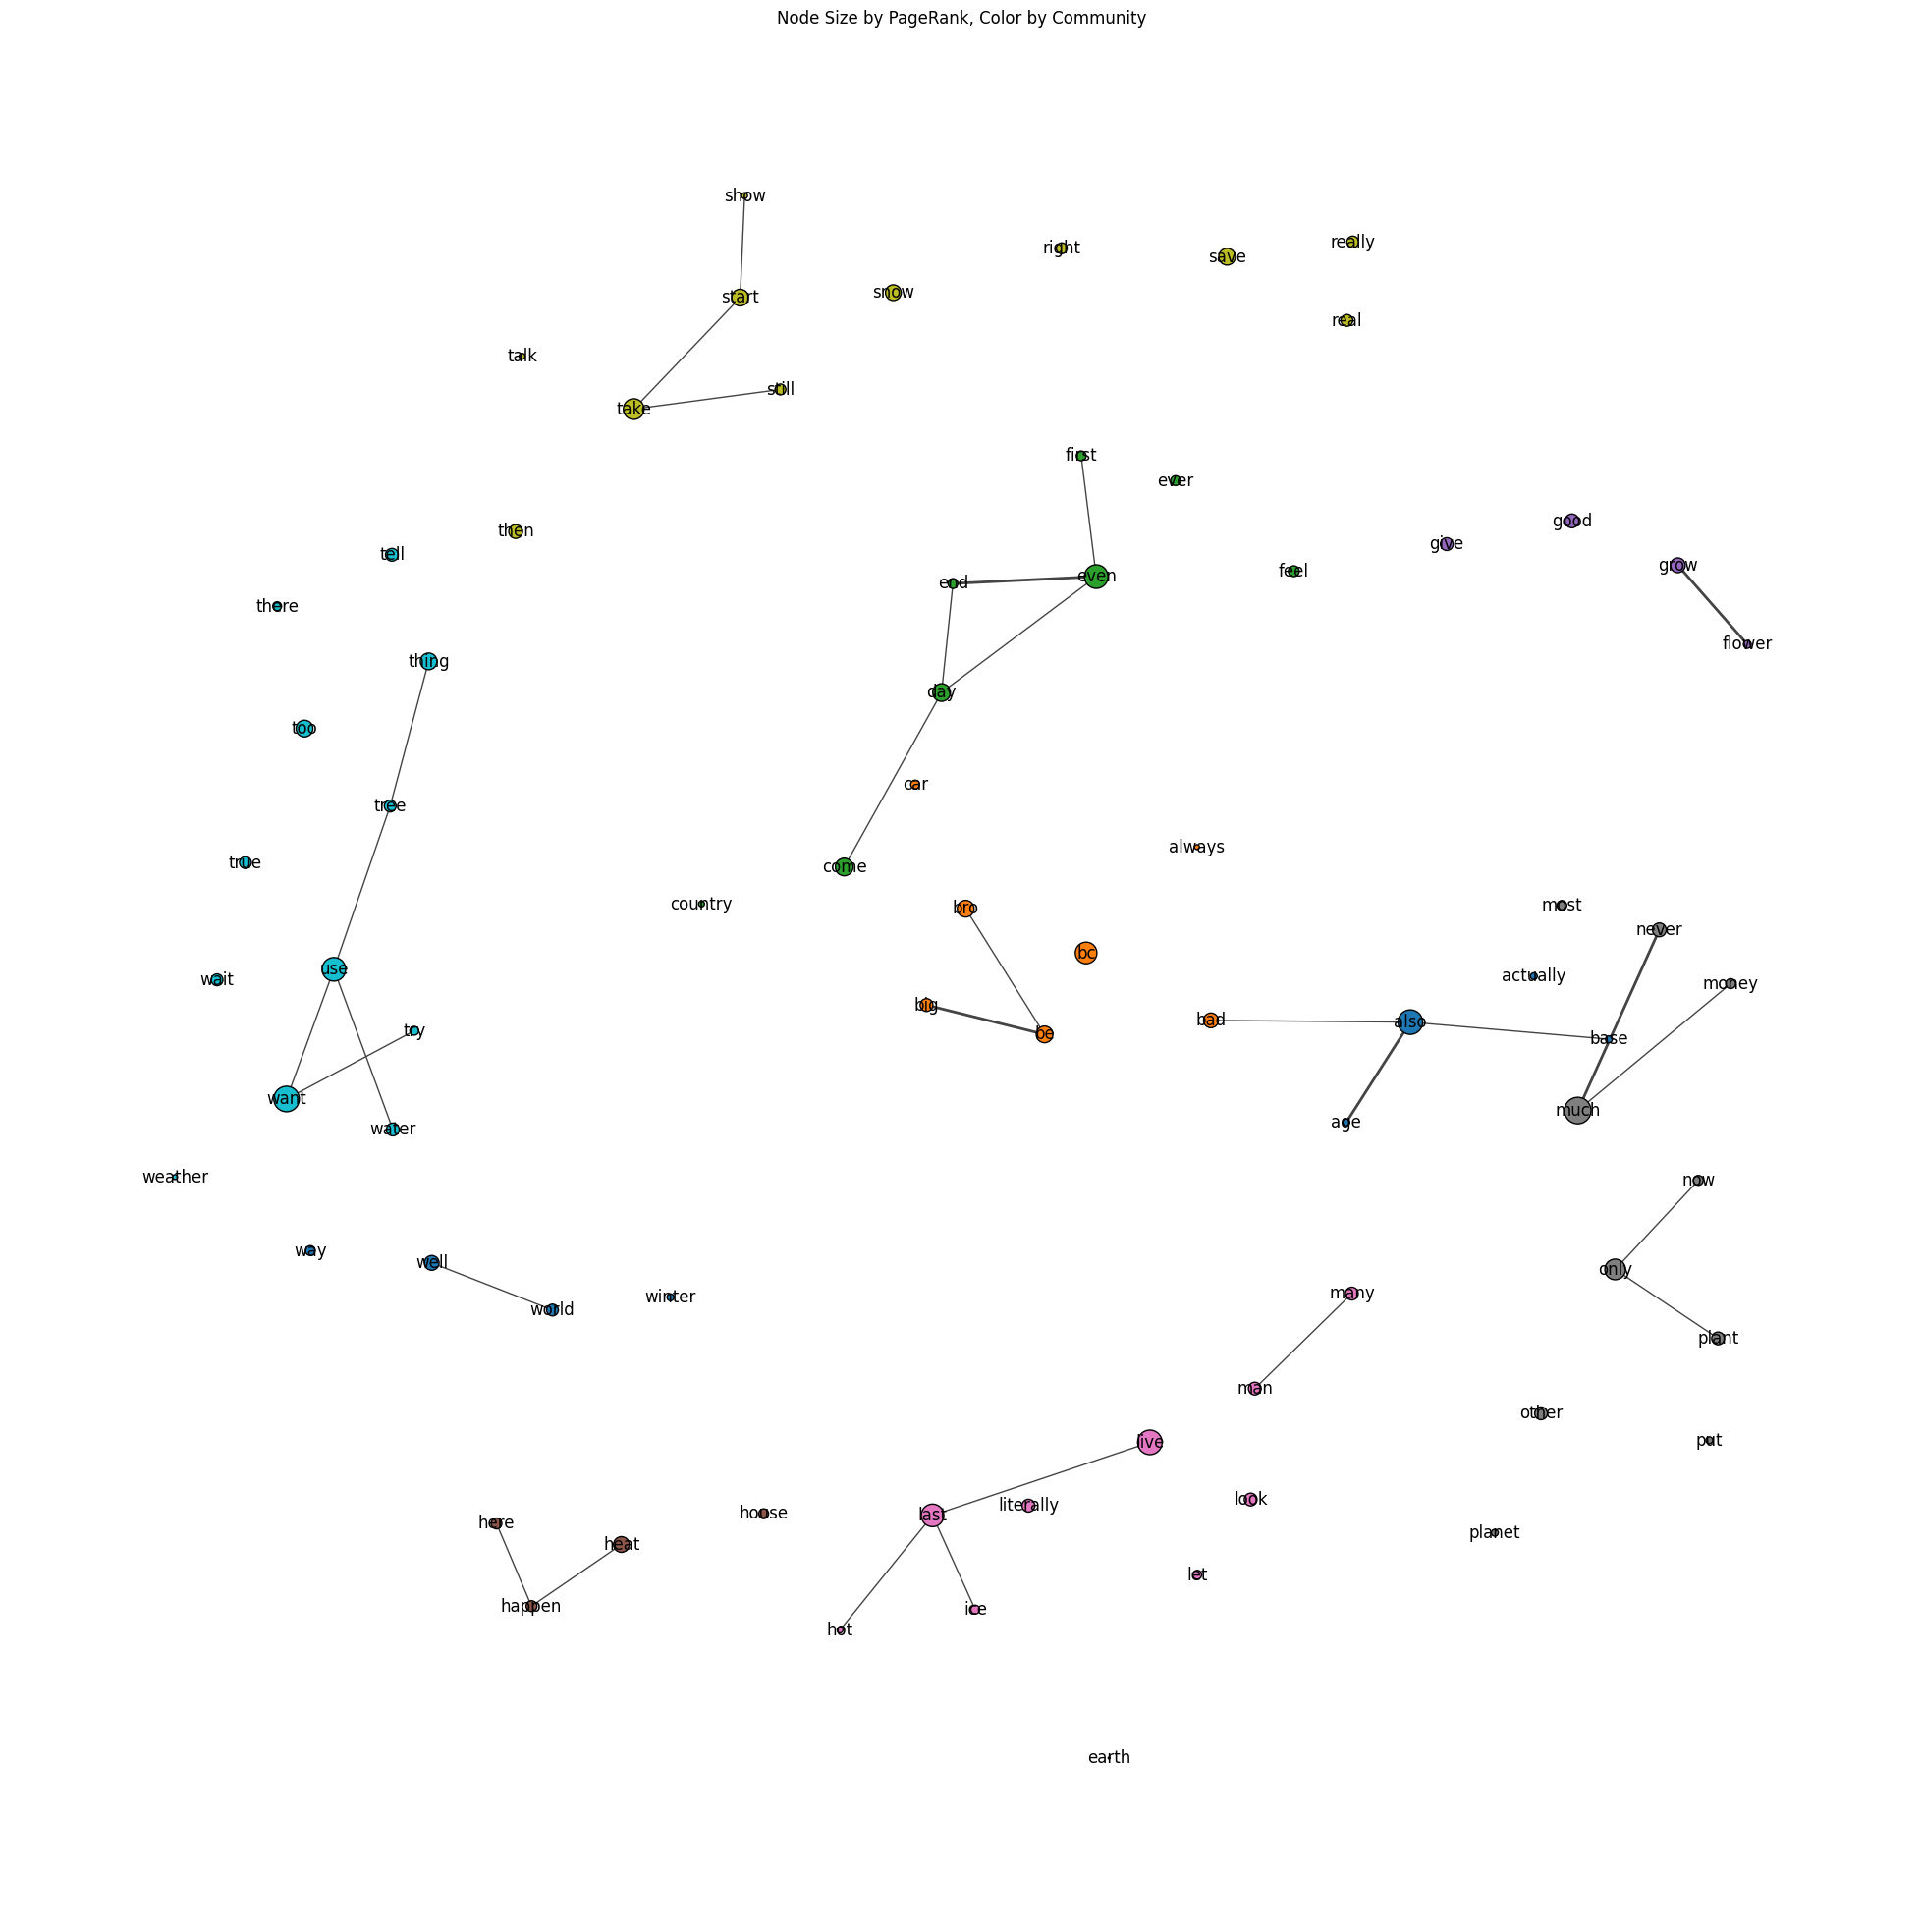

In [140]:
node_sizes_pagerank = [1000 * pr for pr in G.vs["pagerank"]]
community_colors = list(mcolors.TABLEAU_COLORS.values())
node_colors_community = [
    community_colors[mod % len(community_colors)] for mod in G.vs["modularity_class"]
]

fig, ax = plt.subplots(figsize=(25, 25))

ig.plot(
    G,
    vertex_size=node_sizes_pagerank,
    vertex_color=node_colors_community,
    vertex_label=G.vs["_nx_name"],
    edge_width=edge_weights,
    layout=layout_fr,
    target=ax,
    margin=50
)

plt.title("Node Size by PageRank, Color by Community")
plt.show()

In [141]:
G_nx = nx.Graph()

# Convert the nodes
for v in G.vs:
    node_attrs = {key: v[key] for key in v.attributes()}  # Extract node attributes
    G_nx.add_node(v['_nx_name'], **node_attrs)  # Add node with attributes

# Convert the edges
for e in G.es:
    G_nx.add_edge(G.vs[e.source]['_nx_name'], G.vs[e.target]['_nx_name'], weight=e['weight'])

# Check the resulting NetworkX graph
print("Nodes in NetworkX graph:", G_nx.nodes(data=True))
print("Edges in NetworkX graph:", G_nx.edges(data=True))

Nodes in NetworkX graph: [('actually', {'_nx_name': 'actually', 'degree': 1, 'pagerank': 0.0074166524747592555, 'modularity_class': 0}), ('age', {'_nx_name': 'age', 'degree': 1, 'pagerank': 0.0074166524747592555, 'modularity_class': 0}), ('also', {'_nx_name': 'also', 'degree': 4, 'pagerank': 0.025252101067340407, 'modularity_class': 0}), ('always', {'_nx_name': 'always', 'degree': 1, 'pagerank': 0.005952293002082747, 'modularity_class': 1}), ('bad', {'_nx_name': 'bad', 'degree': 3, 'pagerank': 0.015137845619134888, 'modularity_class': 1}), ('base', {'_nx_name': 'base', 'degree': 1, 'pagerank': 0.0074166524747592555, 'modularity_class': 0}), ('bc', {'_nx_name': 'bc', 'degree': 5, 'pagerank': 0.02295124708313722, 'modularity_class': 1}), ('be', {'_nx_name': 'be', 'degree': 4, 'pagerank': 0.017974028895257906, 'modularity_class': 1}), ('big', {'_nx_name': 'big', 'degree': 3, 'pagerank': 0.013797494044260597, 'modularity_class': 1}), ('bro', {'_nx_name': 'bro', 'degree': 4, 'pagerank': 0.0

In [143]:
from pyvis.network import Network
from IPython.display import display, HTML


# Create a pyvis network object
net = Network(notebook=True, cdn_resources='in_line')

# Add NetworkX graph to pyvis
net.from_nx(G_nx)

# Show the network in an HTML file
net.show("network.html")


network.html


In [144]:
display(HTML('network.html'))


In [145]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming G is your NetworkX graph
G = G_nx

# Create a PyVis network object
net = Network(notebook=True, cdn_resources='in_line')

# Define colors based on modularity classes
modularity_classes = list(set(nx.get_node_attributes(G, 'modularity_class').values()))
mod_colors = plt.cm.viridis(np.linspace(0, 1, len(modularity_classes)))

# Map modularity class to a color
modularity_color_map = {mod_class: mod_colors[i] for i, mod_class in enumerate(modularity_classes)}

# Add nodes to PyVis network
for node in G.nodes:
    mod_class = G.nodes[node]['modularity_class']
    pagerank = G.nodes[node].get('pagerank', 0)  # Default to 0 if no pagerank attribute
    size = 20 + 500 * pagerank  # Scaling size based on PageRank
    color = modularity_color_map.get(mod_class, 'gray')  # Default to gray if no modularity class
    label = G.nodes[node].get('_nx_name', node)  # Default to node name if no _nx_name attribute

    # Ensure color is in RGB format or hex string
    if isinstance(color, np.ndarray):  # If color is an ndarray, convert to hex
        color = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

    # Add node to PyVis network with size and color
    net.add_node(node, label=label, size=int(size), color=color)

# Add edges to PyVis network
for u, v in G.edges:
    net.add_edge(u, v)

# Show the network
net.show("network_graph.html")


network_graph.html


In [146]:
display(HTML('network_graph.html'))


In [ ]:
# umap

